# Tutorial: sample data

This notebook shows an illustrative example of how to run cup1d for extracting cosmological constraints from P1D data:

- Set mock data
- Set emulator
- Set likelihood
- Set sampler
- Run sample for a small number of steps

All these steps are implemented in cup1d/cup1d/likelihood/samplerpipeline.py. If you are interested in running cup1d, please take a look at cup1d/scripts/sam_sim.py. That script is parallelized using MPI and includes a bookkeeper taking care of all relevant options.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time, os, sys
import matplotlib.pyplot as plt

# our own modules
import lace
from lace.archive import gadget_archive, nyx_archive
from lace.cosmo import camb_cosmo
from lace.emulator.emulator_manager import set_emulator
from cup1d.p1ds import (
    data_gadget,
    data_nyx,
    data_eBOSS_mock,
    data_Chabanier2019,
    data_Karacayli2022,
    data_Karacayli2023,
    data_Ravoux2023,
)
from cup1d.likelihood import lya_theory, likelihood, emcee_sampler
from cup1d.likelihood.sampler_pipeline import set_archive, set_P1D, set_fid_cosmo, set_like
from cup1d.likelihood.input_pipeline import Args

### Set up arguments

Info about these and other arguments in cup1d.likelihood.input_pipeline.py

In [2]:
# set output directory for this test
output_dir = "."

# args = Args(emulator_label="Pedersen21")
# args = Args(emulator_label="Cabayol23+", training_set="Cabayol23")
args = Args(emulator_label="Nyx_alphap", training_set="Nyx23_Oct2023")
args.n_igm=0
args.n_steps=50
args.n_burn_in=10
args.parallel=False
args.explore=True
args.vary_alphas=True
args.data_label="nyx_central"
args.cosmo_label="nyx_central"
args.igm_label="nyx_central"

### Set archive

In [3]:
archive = set_archive(args.training_set)

### Set emulator

In [4]:
emulator = set_emulator(
    emulator_label=args.emulator_label,
    archive=archive,
)

Using custom archive provided by the user to load emulator
Samples in training_set: 4088
Selected emulator Nyx_alphap
Neural network emulating the optimal P1D of Nyx simulations fitting coefficients to a 6th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed


### Set fiducial cosmology

In [5]:
cosmo_fid = set_fid_cosmo(cosmo_label=args.cosmo_label)

### Set P1D data

We create mock data starting from an mpg simulation, but we can set obs data

In [6]:
data = {"P1Ds": None, "extra_P1Ds": None}
data["P1Ds"], true_sim_igm = set_P1D(
    archive,
    emulator,
    args.data_label,
    cosmo_fid,
    cov_label=args.cov_label,
    apply_smoothing=False
)

No smoothing is applied


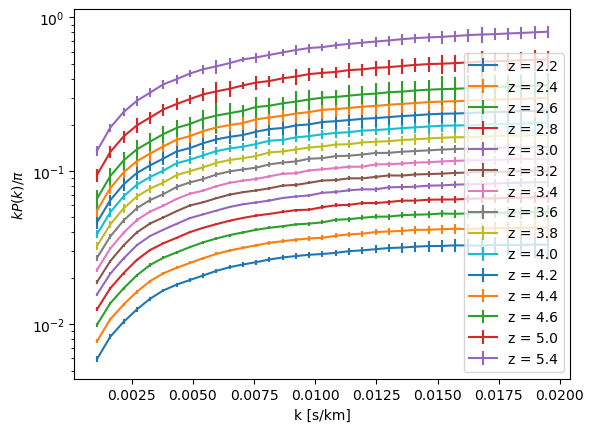

In [7]:
data["P1Ds"].plot_p1d()

### Set likelihood

In [52]:
like = set_like(
    emulator,
    data["P1Ds"],
    data["extra_P1Ds"],
    true_sim_igm,
    args.igm_label,
    args.n_igm,
    cosmo_fid,
    vary_alphas=args.vary_alphas
)

Using 0 parameters for IGM model
free parameters ['As', 'ns', 'nrun']
The fiducial value of tau_eff is zero for z:  [0.]
The fiducial value of gamma is zero for z:  [0.]
The fiducial value of sigT_kms is zero for z:  [0.]
The fiducial value of kF is zero for z:  [0.  2.4 3.6 5.4]


Plot residual between P1D data and emulator for fiducial cosmology (should be the same in this case)

 /home/jchaves/Proyectos/projects/lya/LaCE/lace/emulator/nn_emulator.py:845: UserWarning:Some of the requested k's are lower than the minimum training value k=0.10471976026071429


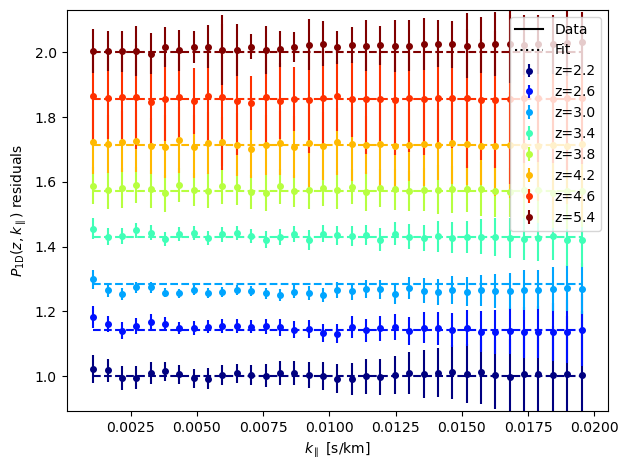

In [11]:
like.plot_p1d(residuals=True, plot_every_iz=2)

Priors for sampling parameters

In [12]:
for p in like.free_params:
    print(p.name, p.value, p.min_value, p.max_value)

As 2.1e-09 7.4e-10 4.11e-09
ns 0.966 0.68 1.32
nrun 0.0 -0.8 0.8


### Set sampler

In [13]:
def log_prob(theta):
    return log_prob.sampler.like.log_prob_and_blobs(theta)

def set_log_prob(sampler):
    log_prob.sampler = sampler
    return log_prob

sampler = emcee_sampler.EmceeSampler(
    like=like,
    rootdir=output_dir,
    save_chain=False,
    nburnin=args.n_burn_in,
    nsteps=args.n_steps,
    parallel=args.parallel,
    explore=args.explore,
    fix_cosmology=args.fix_cosmo,
)
_log_prob = set_log_prob(sampler)

Created directory: ./chain_7
setup with  1  ranks,  121  walkers, and  50  steps
combined steps  7260 (should be close to  7200 )


### Run sampler
It takes less than 2 min on my laptop without any parallelization

In [14]:
%%time
_emcee_sam = sampler.run_sampler(log_func=_log_prob)

set 121 walkers with 3 dimensions
CPU times: user 50.5 s, sys: 10.6 s, total: 1min 1s
Wall time: 44.3 s


### Run minimizer

In [15]:
%%time
ind = np.argmax(sampler.lnprob.reshape(-1))
nparam = sampler.chain.shape[-1]
p0 = sampler.chain.reshape(-1, nparam)[ind, :]
sampler.run_minimizer(log_func=_log_prob, p0=p0)

Minimization improved: -456.9920862020756 -456.90493396160446
MLE: {'$A_s$': 1.9749331390400526e-09, '$n_s$': 1.0286846627455106, '$n_\\mathrm{run}$': -0.01806737136983938, '$\\Delta^2_\\star$': 0.3750811389534579, '$n_\\star$': -2.283540277823453, '$f_\\star$': -0.23421191905154412, '$g_\\star$': 0.9811880991698645, '$\\alpha_\\star$': 0.9674660420848551, '$H_0$': 67.32117}
CPU times: user 584 ms, sys: 142 ms, total: 725 ms
Wall time: 517 ms


### Get plots

Get interesting plots, these are in the folder created with the output

 /home/jchaves/Proyectos/projects/lya/LaCE/lace/emulator/nn_emulator.py:845: UserWarning:Some of the requested k's are lower than the minimum training value k=0.10471976026071429


Can't plot best fit


 /home/jchaves/Proyectos/projects/lya/LaCE/lace/emulator/nn_emulator.py:845: UserWarning:Some of the requested k's are lower than the minimum training value k=0.10471976026071429
Parameter $A_s$ in chain a is not constrained
Parameter $A_s$ in chain a is not constrained


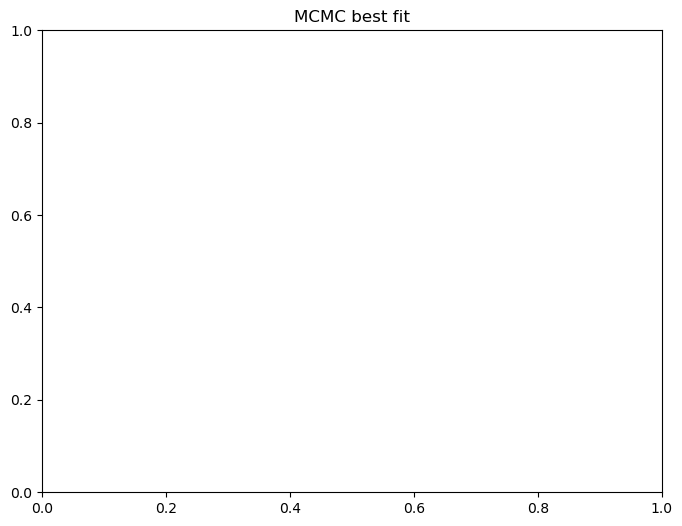

In [30]:
sampler.write_chain_to_file()

In [ ]:
# p1 = {'Delta2_p': 0.6424254870204057, 'n_p': -2.284963361317453, 'alpha_p': -0.21536767260941628, 'mF': 0.8333555955907445, 'gamma': 1.5166829814584781, 'sigT_Mpc': 0.10061115435052223, 'kF_Mpc': 10.614589838852988}
# k = np.linspace(0.1, 5, 50)
# z = 2.2
# res = emulator.emulate_p1d_Mpc(p1, k, z=z, return_covar=True)
# p1d, cov = res
# plt.errorbar(k, k*p1d, k*np.sqrt(np.diag(cov)))
# plt.xscale('log')